In [27]:
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Define the path to the dataset
dataset_path = 'Respiratory_Sound_Database/Respiratory_Sound_Database'
audio_files_path = ('Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/')

diagnosis_df = pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [2]:

def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate=1.0)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model. 
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables. 
        
        Args: dir_: Input directory to the Sound input file.
        
        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]
    
    COPD=[]
    copd_count=0
    
    data = diagnosis_df
    features = 52
    
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                    
                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                
            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')
                    
                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                else: 
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)
                    
                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    
                
    X_data = np.array(X_)
    y_data = np.array(y_)

    
    return X_data, y_data 



In [3]:
x_mfccs, y = mfccs_feature_exteraction(audio_files_path)

In [4]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

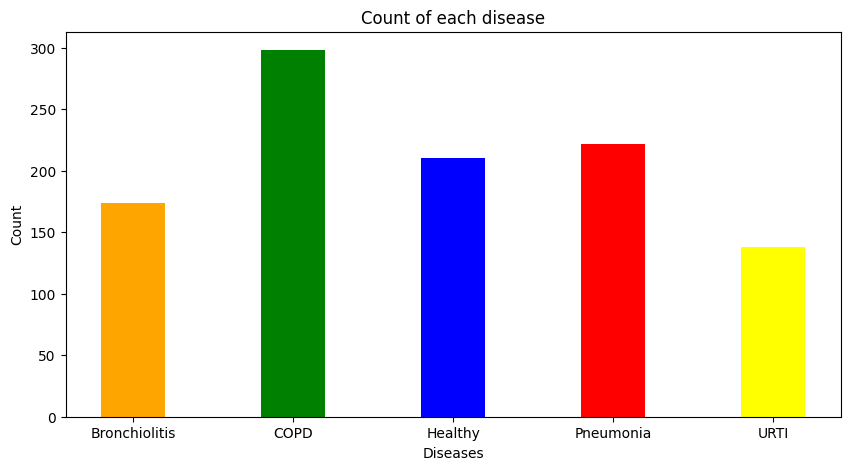

{'Bronchiolitis': 174, 'COPD': 298, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [5]:
augmented_lables_count(y)

In [97]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(x_mfccs.shape)
x_mfccs = x_mfccs.reshape((x_mfccs.shape[0], x_mfccs.shape[1], 1, 1))
print(x_mfccs.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_mfccs, y_categorical, test_size=0.2, random_state=42)

(1042, 52, 1, 1)
(1042, 52, 1, 1)


In [98]:
# Build the model using Input layer
model = Sequential([
    Input(shape=(52, 1, 1)),  # Use Input layer to specify the shape
    Conv2D(32, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.25),
    
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 50, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 11, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,221 (379.77 KB)

 Trainable params: 97,221 (379.77 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
history = model.fit(X_train, y_train, epochs=800, batch_size=8, validation_split=0.2)

Epoch 1/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2460 - loss: 7.7755 - val_accuracy: 0.4072 - val_loss: 1.5074
Epoch 2/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2522 - loss: 1.9804 - val_accuracy: 0.4012 - val_loss: 1.5290
Epoch 3/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2828 - loss: 1.6952 - val_accuracy: 0.3114 - val_loss: 1.5648
Epoch 4/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2979 - loss: 1.6020 - val_accuracy: 0.3533 - val_loss: 1.5444
Epoch 5/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2751 - loss: 1.6262 - val_accuracy: 0.4790 - val_loss: 1.4950
Epoch 6/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3443 - loss: 1.4921 - val_accuracy: 0.4731 - val_loss: 1.4570
Epoch 7/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3461 - loss: 1.4997 - val_accuracy: 0.4132 - val_loss: 1.4554
Epoch 8/800
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3734 - loss: 1.4934 - val_accuracy: 0.5030 - v

In [100]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8600 - loss: 0.4457 
Test accuracy: 0.8660287261009216


In [101]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

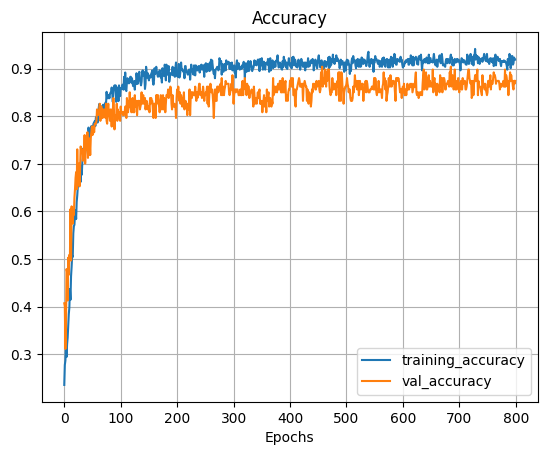

In [102]:
plot_loss_curves(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


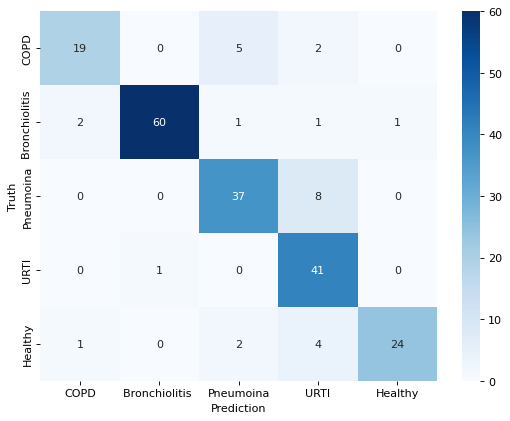

In [103]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

preds = model.predict(X_test)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [104]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       0.86      0.73      0.79        26
Bronchiolitis        0.98      0.92      0.95        65
     Pneumoina       0.82      0.82      0.82        45
          URTI       0.73      0.98      0.84        42
       Healthy       0.96      0.77      0.86        31

      accuracy                           0.87       209
     macro avg       0.87      0.85      0.85       209
  weighted avg       0.88      0.87      0.87       209



In [110]:
import random
val=[]
#separate .wav files from directory stored in audio_data
all_files = os.listdir(audio_files_path)
    
# Filter out only .wav files
wav_files = [file for file in all_files if file.endswith('.wav')]
random_wav_file = random.choice(wav_files)

dir_ = os.path.join(audio_files_path, random_wav_file)

features = 52

soundDir = ''#'/kaggle/input/respiratory-test'
data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
val.append(mfccs)
print(val)
val = np.array(val)
val = val.reshape((val.shape[0], val.shape[1], 1, 1))
print(val.shape)

classes[np.argmax(model.predict(val))]

[array([-5.9668085e+02,  1.0924364e+02,  2.5014393e+01,  5.9666052e+00,
        1.2946216e+01,  1.2722686e+01,  1.4474893e+01,  1.1872929e+01,
        1.8956131e+00,  3.5495005e+00,  1.2886603e+01,  9.3508348e+00,
        2.8288088e+00,  4.5888534e+00,  2.3858774e+00, -1.5446075e+00,
        2.5995677e+00,  4.9501262e+00,  7.6937193e-01,  5.3075904e-01,
        3.6525557e+00,  2.6600513e+00,  8.9910406e-01,  2.6053274e-01,
       -3.5575289e-01,  1.9221152e+00,  3.2520812e+00,  2.0491486e+00,
        4.0071836e+00,  4.8923073e+00,  2.8656206e+00,  3.4571218e+00,
        3.7263196e+00,  1.8445675e+00,  1.1344208e+00,  1.4087774e+00,
        1.9497685e+00,  2.7645855e+00,  2.9676058e+00,  1.5278828e+00,
        6.4719075e-01,  2.2913055e+00,  2.1433382e+00,  6.9117010e-02,
        6.1611074e-01,  1.8824590e+00,  8.1234336e-01, -2.6259899e-01,
        6.9333839e-01,  9.6634960e-01,  1.2441330e-02,  1.0194467e+00],
      dtype=float32)]
(1, 52, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


'Healthy'